In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import datasets,transforms
import os
from torch.utils.data import DataLoader
import os
from torchinfo import summary
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"
torch.cuda.empty_cache()

In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
train_dir=r"F:\vit\train_cnn_dataset"
test_dir=r"F:\vit\test_cnn_dataset"

# create dataset and dataloader

In [4]:
image_size=224
manual_transform=transforms.Compose([
    transforms.Resize((image_size)),
    transforms.ToTensor()])
manual_transform

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [5]:
def create_dataloader(
        train_dir,
        test_dir,
        batch_size,
        image_size
):
    manual_transforms=transforms.Compose([
    transforms.Resize((image_size)),
    transforms.ToTensor()])

    train_data=datasets.ImageFolder(train_dir,transform=manual_transforms)
    test_data=datasets.ImageFolder(test_dir,transform=manual_transforms)

    train_dataloader=DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True
    )
    test_dataloader=DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True
    )

    return train_dataloader,test_dataloader, train_data.classes


In [6]:
train_dataloader,test_dataloader,labels=create_dataloader(
        train_dir,
        test_dir,
        batch_size=64,
        image_size=224)

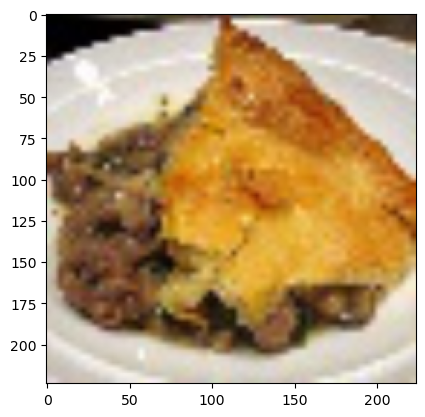

In [7]:
img,l=next(iter(train_dataloader))
plt.imshow(img[0].permute(1,2,0))

# image embeddings

In [8]:
class patches(nn.Module):

    def __init__(self,
                 
                 in_channel,
                 embeddings,
                 patch_size):
        super().__init__()

        self.conv_patch=nn.Conv2d(
            in_channels=in_channel,
            out_channels=embeddings,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )
        self.f1=nn.Flatten(start_dim=2,end_dim=3)
    
    def forward(self,x):
        x=self.conv_patch(x)
        x=self.f1(x)

        return x.permute(0,2,1)

In [9]:
img.shape

torch.Size([64, 3, 224, 224])

In [10]:
c=patches(in_channel=3,embeddings=256,patch_size=16)
c(img)

tensor([[[ 2.8442e-03,  1.1551e-02,  7.0933e-03,  ..., -2.5278e-02,
          -5.3941e-02, -2.6020e-02],
         [-9.0848e-03,  1.1379e-02, -1.6017e-02,  ..., -3.4808e-02,
          -1.1183e-01, -6.5060e-03],
         [-1.7780e-01, -2.8716e-02, -9.9943e-02,  ..., -2.0594e-01,
          -3.9193e-01,  7.5651e-02],
         ...,
         [-3.0554e-01, -1.4640e-01,  1.1817e-01,  ..., -1.2523e-01,
          -1.0783e+00,  9.6462e-02],
         [-3.4892e-01, -8.2192e-02,  5.6988e-02,  ..., -3.5030e-02,
          -1.1219e+00,  1.1003e-01],
         [-3.6395e-01, -5.2847e-02,  9.2300e-02,  ..., -8.5636e-02,
          -1.0585e+00,  1.5164e-01]],

        [[-6.1958e-02, -2.0129e-02,  3.4622e-02,  ..., -5.8689e-02,
          -3.2911e-01, -3.4079e-02],
         [-1.0392e-01, -1.4125e-02,  4.1653e-02,  ..., -1.1035e-01,
          -3.3844e-01,  3.3524e-02],
         [-2.3314e-01, -1.4151e-01,  1.7701e-02,  ..., -1.5579e-01,
          -9.1113e-01, -3.9977e-02],
         ...,
         [-1.1457e-01, -7

In [11]:
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
img, label = image_batch[0], label_batch[0]

In [12]:
img.shape

torch.Size([3, 224, 224])

In [17]:
# 1. Set patch size
patch_size = 16
img1=img

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {img1.shape}")
height, width = img1.shape[1], img1.shape[2]

Image tensor shape: torch.Size([3, 224, 224])


In [19]:
x = img1.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

Input image with batch dimension shape: torch.Size([1, 3, 224, 224])


In [20]:
patch_embedding_layer = patches(3,768,16)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

Patching embedding shape: torch.Size([1, 196, 768])


In [21]:
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape} {batch_size} {embedding_dimension}")

Class token embedding shape: torch.Size([1, 1, 768]) 1 768


In [22]:
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

Patch embedding with class token shape: torch.Size([1, 197, 768])


In [23]:
number_of_patches = int((224 * 224) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, 768),
                                  requires_grad=True) # make sure it's learnable

In [24]:
position_embedding

Parameter containing:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True)

In [25]:
# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")
#patch_and_position_embedding

print(patch_and_position_embedding)  #1 is added in the beginning of each

Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.3688, 1.2239, 1.1514,  ..., 1.0323, 0.7735, 1.4307],
         [0.6461, 1.1968, 1.0988,  ..., 1.0426, 0.9407, 1.3648],
         ...,
         [0.4978, 1.2412, 1.1425,  ..., 1.0491, 0.8796, 1.4936],
         [0.4834, 1.2448, 1.1518,  ..., 1.0280, 0.8707, 1.5336],
         [0.3979, 1.2912, 1.1839,  ..., 1.0239, 0.8465, 1.5935]]],
       grad_fn=<AddBackward0>)


# multihead attention

In [26]:
class multihead(nn.Module):
    def __init__(self,
                embed_dim,
                att_dropout,
                 heads ):
        super().__init__()

        self.layer_norm_1=nn.LayerNorm(normalized_shape=embed_dim)
        self.multi_att= nn.MultiheadAttention(embed_dim=embed_dim,
                                              num_heads=heads,
                                              dropout=att_dropout)
        
    def forward(self,x):
        x=self.layer_norm_1(x)
        attn_output,_=self.multi_att(x,x,x)
        
        return attn_output



In [27]:
class mlp_hd(nn.Module):
    def __init__(self,
                 embed_dim,
                 mlp_out,
                 mlp_dropout):
        super().__init__()

        self.layer_norm_1=nn.LayerNorm(normalized_shape=embed_dim)
        self.fc=nn.Sequential(
            nn.Linear(in_features=embed_dim,
                      out_features=mlp_out),
            nn.GELU(),
            nn.Dropout(p=mlp_dropout),
            nn.Linear(in_features=mlp_out,
                      out_features=embed_dim),
            nn.Dropout(p=mlp_dropout)

        )

    def forward(self,x):
        x=self.layer_norm_1(x)
        x=self.fc(x)
        return x


In [ ]:
class Multihead(nn.Module):
    def __init__(self,
                 embed_dim,
                 att_dropout,
                 heads):
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(normalized_shape=embed_dim)
        self.multi_att = nn.MultiheadAttention(embed_dim=embed_dim,
                                              num_heads=heads,
                                              dropout=att_dropout)

    def forward(self, x):
        # compute Q, K, V for each head
        Q, K, V = self.W_q(x), self.W_k(x), self.W_v(x)

        # compute attention weights
        attention_weights = torch.bmm(Q, K.transpose(1, 2))
        attention_weights = self.attn_drop(attention_weights)
        attention_weights = torch.nn.functional.softmax(attention_weights / sqrt_k, dim=-1)

        # compute context vector
        context = torch.bmm(attention_weights, V)

        # add residual connection and layer norm
        x = self.layer_norm_1(x + context)

        # output the attention weights
        return x, attention_weights

In [28]:
class transformer_block(nn.Module):
    def __init__(self,
                 embed_dim,
                 att_dropout,
                 mlp_dropout,
                 head,
                 mlp_out):
        super().__init__()

        self.multi_head=multihead(embed_dim=embed_dim,
                                att_dropout=att_dropout,
                                heads=head)

        self.mlp_1=mlp_hd(embed_dim=embed_dim,
                     mlp_out=mlp_out,
                     mlp_dropout=mlp_dropout)
        
    def forward(self,x):
        x=self.multi_head(x)+x
        x=self.mlp_1(x)+x

        return x
        


In [29]:
c=transformer_block(embed_dim=768,att_dropout=0.6,
                    mlp_dropout=0.3,
                    head=4,
                    mlp_out=256)

In [30]:
summary(c)

Layer (type:depth-idx)                                  Param #
transformer_block                                       --
├─multihead: 1-1                                        --
│    └─LayerNorm: 2-1                                   1,536
│    └─MultiheadAttention: 2-2                          1,771,776
│    │    └─NonDynamicallyQuantizableLinear: 3-1        590,592
├─mlp_hd: 1-2                                           --
│    └─LayerNorm: 2-3                                   1,536
│    └─Sequential: 2-4                                  --
│    │    └─Linear: 3-2                                 196,864
│    │    └─GELU: 3-3                                   --
│    │    └─Dropout: 3-4                                --
│    │    └─Linear: 3-5                                 197,376
│    │    └─Dropout: 3-6                                --
Total params: 2,759,680
Trainable params: 2,759,680
Non-trainable params: 0

# vision tranformer

In [31]:
class vision_trans(nn.Module):
    def __init__(self,
                 img_size=224,
                 in_channel=3,
                 embed_dim=128,
                 patch_size=16,
                 att_dropout=0,
                 mlp_dropout=0.1,
                 head=8,
                 mlp_out=256,
                 trans_layer=12,
                 num_classes=2,
                 embed_dropout=0.1
                 ) :
        super().__init__()

        self.num_patches=(img_size*img_size)//patch_size**2

        self.class_embed=nn.Parameter(data=torch.randn(1,1,embed_dim),
        requires_grad = True)
        self.embedding_dropout = nn.Dropout(p=embed_dropout)

        self.position_embed=nn.Parameter(data=torch.randn(1,self.num_patches+1,embed_dim),
                                        requires_grad=True)
        self.patch_embed=patches(in_channel=in_channel,
                                 patch_size=patch_size,
                                 embeddings=embed_dim)
        self.trans_encoder=nn.Sequential(*[transformer_block(embed_dim=embed_dim,
                                                             mlp_dropout=mlp_dropout,
                                                             att_dropout=att_dropout,
                                                             head=head,
                                                             mlp_out=mlp_out
                                                             ) for _ in range(trans_layer)])
        self.classy=nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim,
                      out_features=num_classes)
        )

    def forward(self,x):

        batch_size=x.shape[0]

        class_token=self.class_embed.expand(batch_size,-1,-1)

        x=self.patch_embed(x)

        x=torch.cat((class_token,x),dim=1)

        x=self.position_embed+x

        x=self.embedding_dropout(x)

        x=self.trans_encoder(x)

        x=self.classy(x[:,0])

        return x




        

# Train model

In [32]:
vit=vision_trans()
vit.to(device)

vision_trans(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embed): patches(
    (conv_patch): Conv2d(3, 128, kernel_size=(16, 16), stride=(16, 16))
    (f1): Flatten(start_dim=2, end_dim=3)
  )
  (trans_encoder): Sequential(
    (0): transformer_block(
      (multi_head): multihead(
        (layer_norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (multi_att): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
      )
      (mlp_1): mlp_hd(
        (layer_norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (fc): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=256, out_features=128, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): transformer_block(
      (multi_head

In [33]:
opt=torch.optim.Adam(vit.parameters(),
                     lr=5e-3)
loss_fn=torch.nn.CrossEntropyLoss()

In [38]:
import torch
torch.cuda.empty_cache()
from tqdm import tqdm

In [43]:
device

'cuda'

In [44]:
running_loss=0
for epoch in range(0,10):
    running_loss,val_loss=0,0
    for image,label in tqdm(train_dataloader):

        opt.zero_grad()
        image=image.to(device)
        label=label.to(device)
        #print(image.shape)
        outputs=vit(image)
        loss=loss_fn(outputs,label)
        loss.backward()
        opt.step()
        running_loss += loss.item()

    with torch.no_grad():
        for image,label in tqdm(test_dataloader):
            image=image.to(device)
            label=label.to(device)

            outputs=vit(image)
            loss_val=loss_fn(outputs,label)
            val_loss+=loss_val.item()

    print(f"Epoch {epoch+1} \n Training Loss {running_loss} \n Validation Loss {val_loss}")


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Epoch 1 
 Training Loss 41.702628791332245 
 Validation Loss 2.772772490978241


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


Epoch 2 
 Training Loss 41.125309348106384 
 Validation Loss 2.7796295881271362


100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


Epoch 3 
 Training Loss 40.999526500701904 
 Validation Loss 2.7774133682250977


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


Epoch 4 
 Training Loss 41.17248433828354 
 Validation Loss 2.7811504006385803


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Epoch 5 
 Training Loss 41.01344180107117 
 Validation Loss 2.7739416360855103


100%|██████████| 4/4 [00:01<00:00,  3.09it/s]


Epoch 6 
 Training Loss 41.0226868391037 
 Validation Loss 2.784906506538391


100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Epoch 7 
 Training Loss 41.18538761138916 
 Validation Loss 2.7963662147521973


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


Epoch 8 
 Training Loss 41.05864155292511 
 Validation Loss 2.777689039707184


100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


Epoch 9 
 Training Loss 41.07153934240341 
 Validation Loss 2.7729594111442566


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

Epoch 10 
 Training Loss 41.06705468893051 
 Validation Loss 2.781476855278015
